In [14]:
import pickle
import keras
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import pickle
import cv2
import skimage.io

import matplotlib.cm 
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Conv2D, MaxPooling2D, Input, InputLayer, Reshape
from keras.callbacks import EarlyStopping
from keras.metrics import binary_accuracy
from keras.utils import plot_model
from keras import backend as K

from tqdm import tqdm_notebook as tqdm


import sys

#get GPU running !
config = tf.ConfigProto()
config.gpu_options.allow_growth = False
sess = tf.Session(config=config)
keras.backend.set_session(sess)

import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.WARN)

In [15]:
def get_images_fct(DATA_PATH,IMAGE_PATH,PATH, df_data):
    '''
    Returns a list of images
    '''
    PATH = DATA_PATH+IMAGE_PATH+PATH
    im_names = df_data.filename.unique()
    filenames = [os.path.join(PATH, name) + '.jpg' for name in im_names]
    images = skimage.io.imread_collection(filenames)
    print('Number of images: ', len(images))
    return images

In [21]:
dataset_path= './Data/images/'

# Load images
DATA_PATH = './Data'#"../../project-data"
IMAGE_PATH = "/images"
TRAIN_PATH = "/train"
TEST_PATH = "/test"
VALIDATION_PATH = "/validation"

train_data = pd.read_pickle("df_train.pickle")
test_data = pd.read_pickle("df_test.pickle")
val_data = pd.read_pickle("df_val.pickle")

train_images = get_images_fct(DATA_PATH,IMAGE_PATH, TRAIN_PATH, train_data)
test_images = get_images_fct(DATA_PATH,IMAGE_PATH, TEST_PATH, test_data)
val_images = get_images_fct(DATA_PATH,IMAGE_PATH, VALIDATION_PATH, val_data)

Number of images:  532
Number of images:  33
Number of images:  103


## Model

In [5]:
target_size=(40,40)

In [26]:
model = Sequential()

#feature extraction part
model.add(Conv2D(input_shape=(target_size[0],target_size[1], 3), filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#classification part
_,b,c,d=model.output_shape #hardcode the reshape for cv.dnn issues
model.add(Reshape(target_shape=[b*c*d])) 
model.add(Dense(64, activation='selu'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
model.load_weights('Cnn.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 17, 17, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 288)               0         
__________

### Sliding window

In [10]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [82]:
#Size of the sliding windows (a bit bigger than a varroa which is approximately a square of 32x32)
(winW, winH) = (40, 40)
img=train_images[0]

#Train images processing
probas=np.float32(np.zeros_like(img[:,:,0]))
mask=np.float32(np.zeros_like(img[:,:,0])) #how many time a pixels gets updates

# loop over the sliding window
for (x, y, window) in sliding_window(img, stepSize=20, windowSize=(winW, winH)):
    
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue
    else:
        window=window[np.newaxis, ...]
        probas[y:y+20,x:x+20] = probas[y:y+20,x:x+20] + model.predict_proba(window)[0][0]
        mask[y:y+20,x:x+20] +=  mask[y:y+20,x:x+20] + 1

probas=probas/mask #get the mean of the predictions for each pixel

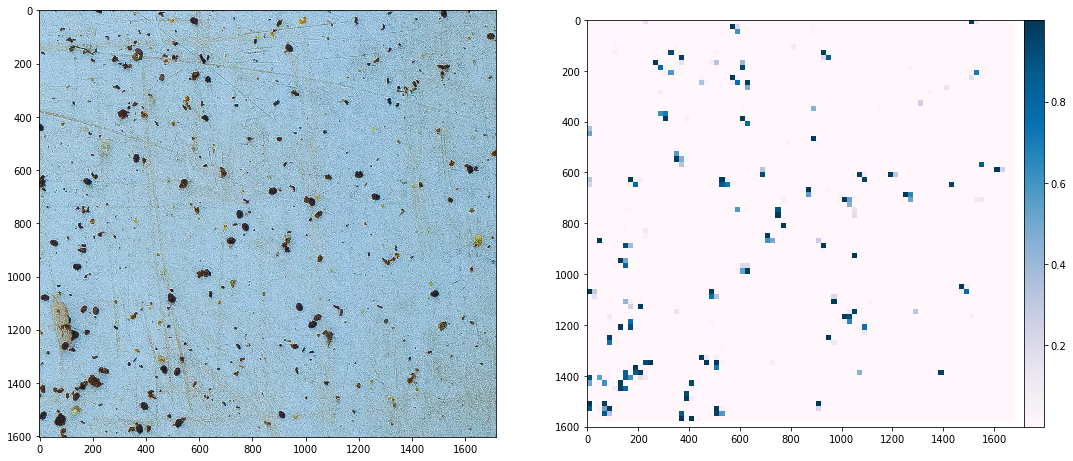

In [94]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
a=plt.imshow(probas, cmap='PuBu')
plt.colorbar(a, fraction=0.0445, pad=0)
plt.show()